# Next frame prediction

The project consists of predicting the next frame in a short movie sequence.

For this project, we shall use the Moving MNIST dataset, composed of 10,000 video sequences, each consisting of 20 frames. In each video sequence, two digits move independently around the frame, which has a spatial resolution of 64×64 pixels. The digits frequently intersect with each other and bounce off the edges of the frame.

While each sequence has a lenght of 20, your are supposed to use **only 3 consecutive frames as input**, and **predict the next one**.

The metric used to evalaute the quality of the predicted frame is Mean Squared Error.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers

import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ds = tfds.as_numpy(tfds.load(
    'moving_mnist',
    split='test',
    batch_size=-1
))
sequences = ds['image_sequence']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/moving_mnist/1.0.0.incompleteLH4YNX/moving_mnist-test.tfrecord*...:   0%| …

Dataset moving_mnist downloaded and prepared to /root/tensorflow_datasets/moving_mnist/1.0.0. Subsequent calls will reuse this data.


In [3]:
sequences = np.squeeze(np.swapaxes(sequences, 1, 4),axis=1)/255.
print(sequences.shape)
print(np.min(sequences),np.max(sequences))

(10000, 64, 64, 20)
0.0 1.0


In [4]:
trainset = sequences[:8000]
valset = sequences[8000:9000]
testset = sequences[9000:10000]

In [5]:
def image_generator(dataset,batchsize=16,seqlen=4):
    while True:
      batch_x = np.zeros((batchsize,64,64,seqlen-1))
      batch_y = np.zeros((batchsize,64,64,1))
      ran = np.random.randint(dataset.shape[0],size=batchsize)
      minibatch = dataset[ran]
      #these sequences have length 20; we reduce them to seqlen
      for i in range(batchsize):
          random_start = np.random.randint(0,20-seqlen)
          random_end = random_start+seqlen-1
          batch_x[i] = minibatch[i,:,:,random_start:random_end]
          batch_y[i] = minibatch[i,:,:,random_end:random_end+1]
          #print(batch_x.shape,batch_y.shape)
          #print(batch_x.min(),batch_x.max())
          #print(batch_x.min(),batch_x.max())
      yield(batch_x,batch_y)

In [6]:
prova_gen = image_generator(testset,batchsize=1,seqlen=4)

In [7]:
sample_x, sample_y = next(prova_gen)

In [8]:
print(type(sample_x))

<class 'numpy.ndarray'>


In [9]:
def show_list(images): #takes in input a list of images and plot them
    size = len(images)
    plt.figure(figsize=(10, 10 * size))
    for i in range(size):
        plt.subplot(1, size, i + 1)
        plt.imshow(images[i],cmap='gray',)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

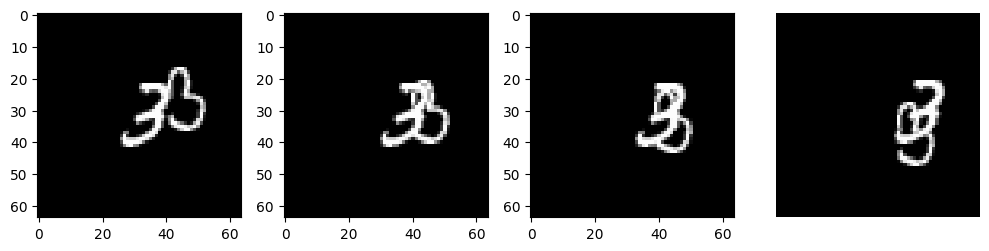

In [10]:
all = [sample_x[0,:,:,i] for i in range(3)]+[sample_y[0,:,:,0]]
show_list(all)

In [11]:
batch = 32

In [12]:
train_gen = image_generator(trainset, batchsize= batch)
val_gen = image_generator(valset, batchsize= batch)
test_gen = image_generator(testset, batchsize= batch)

In [13]:
sample_x, sample_y = next(train_gen)
sample_x.shape, sample_y.shape

((32, 64, 64, 3), (32, 64, 64, 1))

# The Model

The model, personalized SimVP, consists of an encoder, a
translator and a decoder built on CNN only.
1. The encoder is used to extract spatial features,
2. the translator learns temporal evolution, and
3. the decoder integrates spatio-temporal information to predict future frame.


## Model Structure

The model is based on this structure.

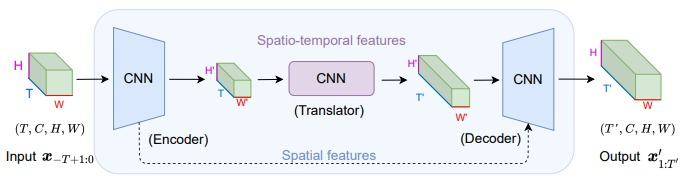

where in this case the number of channels C for Moving MNIST is 1 (single channel for grayscale).

The input/output shape is (H, W, T) for Height, Width and Frames

Input is $x[0 : (n-1)]$

Output is $x[n]$

where n is number of frames

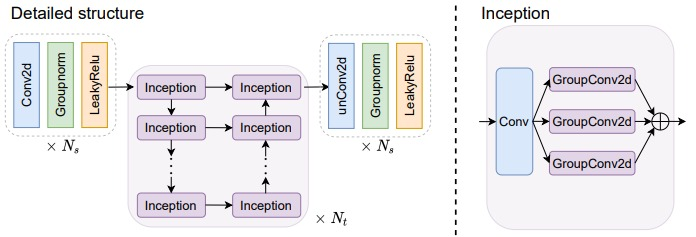

The Inception Module used here is a generic Inception module with dimention reduction.

kernel sizes [1,3,5,7]

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LayerNormalization, LeakyReLU, Input, MaxPooling2D, concatenate

### Encoder

The encoder stacks $Ns$ ConvNormReLU blocks
(Conv2d+LayerNorm+LeakyReLU) to extract spatial features, i.e., convoluting on (H, W).

The hidden feature is:
$z_{i} = \sigma (\mathrm {LayerNorm} (\mathrm {Conv2d}(z_{i-1}))), 1 \leq i \leq N_s $

where the input $zi−1$ and output $zi$ shapes are (H, W, 3)
and (Hˆ, Wˆ, Tˆ ), respectively.


In [15]:
def stride_generator(N_s, reverse=False):
    strides = [1, 2] * 10
    if reverse:
        return list(reversed(strides[:N_s]))
    else:
        return strides[:N_s]

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, N_s):
        super(Encoder, self).__init__()
        self.N_s = N_s
        self.conv_norm_relu_blocks = []

        # Get the strides using stride_generator
        strides = stride_generator(N_s,reverse=True)

        for i, stride in zip(range(1, N_s + 1), strides):
            self.conv_norm_relu_blocks.append(self.create_conv_norm_relu_block(stride))

    def create_conv_norm_relu_block(self,stride):
        return tf.keras.Sequential([
            Conv2D(64, (3, 3), strides=(stride, stride),  padding='same'),
            LayerNormalization(),
            LeakyReLU(alpha=0.2)
        ])

    def call(self, inputs):
        z_i_minus_1 = inputs  # shape (batch_size, H, W, 3)

        for conv_norm_relu_block in self.conv_norm_relu_blocks:
            z_i = conv_norm_relu_block(z_i_minus_1)  # shape (batch_size, Hˆ, Wˆ, 64)
            z_i_minus_1 = z_i

        return z_i

In [22]:
encoder = Encoder(3)
encoder.build((None, 64, 64, 3))
encoder.summary()
total_params = encoder.count_params()

print("Total Parameters:", total_params)

Model: "encoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 64, 64, 64)        1920      
                                                                 
 sequential_22 (Sequential)  (None, 32, 32, 64)        37056     
                                                                 
 sequential_23 (Sequential)  (None, 32, 32, 64)        37056     
                                                                 
Total params: 76,032
Trainable params: 76,032
Non-trainable params: 0
_________________________________________________________________
Total Parameters: 76032


### Translator

The translator employs $Nt$ Inception modules to learn temporal evolution, i.e., convoluting on (Hˆ, Wˆ). The Inception module consists of a bottleneck
Conv2d with 1×1 kernel followed by parallel Conv2d
operators.

The hidden feature is:
$z_{j} = \mathrm {Inception}( z_{j-1} ), N_s < j \leq N_s+N_t $

where the inputs $zj−1$ and output $zj$ shapes are (Hˆ, Wˆ, C ) and ( H', W ', C ).

In [23]:
class Translator(tf.keras.Model):
    def __init__(self, N_s, N_t):
        super(Translator, self).__init__()
        self.N_s = N_s
        self.N_t = N_t
        self.inception_layers = []

        for j in range(N_s + 1, N_s + N_t + 1):
            self.inception_layers.append(self.create_inception_module())

    def create_inception_module(self):
        tower_1 = tf.keras.Sequential([
            Conv2D(64, (1, 1), padding='same', activation='relu'),
            Conv2D(64, (3, 3), padding='same', activation='relu')
        ])

        tower_2 = tf.keras.Sequential([
            Conv2D(64, (1, 1), padding='same', activation='relu'),
            Conv2D(64, (5, 5), padding='same', activation='relu')
        ])

        tower_3 = tf.keras.Sequential([
            Conv2D(64, (1, 1), padding='same', activation='relu'),
            Conv2D(64, (7, 7), padding='same', activation='relu')
        ])

        tower_4 = tf.keras.Sequential([
            MaxPooling2D((3, 3), strides=(1, 1), padding='same'),
            Conv2D(64, (1, 1), padding='same', activation='relu')
        ])

        return [tower_1, tower_2, tower_3, tower_4]

    def call(self, inputs):
        z_j_minus_1 = inputs  # shape (batch_size, Hˆ, Wˆ, 64)

        for inception in self.inception_layers:
            tower_1_output = inception[0](z_j_minus_1)
            tower_2_output = inception[1](z_j_minus_1)
            tower_3_output = inception[2](z_j_minus_1)
            tower_4_output = inception[3](z_j_minus_1)

            z_j_minus_1 = concatenate([tower_1_output, tower_2_output, tower_3_output, tower_4_output], axis=-1) # shape (batch_size, H', W', 64)

        return z_j_minus_1


In [24]:
translator = Translator(3, 3)
translator.build((None, 64, 64, 3))
translator.summary()
total_params = translator.count_params()

print("Total Parameters:", total_params)

Model: "translator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_24 (Sequential)  (None, 64, 64, 64)        37184     
                                                                 
 sequential_25 (Sequential)  (None, 64, 64, 64)        102720    
                                                                 
 sequential_26 (Sequential)  (None, 64, 64, 64)        201024    
                                                                 
 sequential_27 (Sequential)  (None, 64, 64, 64)        256       
                                                                 
 sequential_28 (Sequential)  (None, 64, 64, 64)        53376     
                                                                 
 sequential_29 (Sequential)  (None, 64, 64, 64)        118912    
                                                                 
 sequential_30 (Sequential)  (None, 64, 64, 64)       

### Decoder

The decoder utilizes $Ns$ unConvNormReLU
blocks (ConvTranspose2d+GroupNorm+LeakyReLU) to
reconstruct the ground truth frames, which convolutes on (H', W'). The hidden feature is:
$z_{k} = \sigma (\mathrm {GroupNorm} (\mathrm {unConv2d}(z_{k-1}))),\\ N_s+N_t<k \leq 2N_s+N_t $

where the shapes of input $zk−1$ and output $zk$ are
(H', W', C ) and (H, W, 1), respectively. Using ConvTranspose2d to serve as the unConv2d operator.

In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, N_s, N_t):
        super(Decoder, self).__init__()
        self.N_s = N_s
        self.N_t = N_t
        self.unconv_norm_relu_blocks = []

        strides = stride_generator(2 * N_s + N_t, reverse=True)

        for k, stride in zip(range(N_s + N_t + 1, 2 * N_s + N_t + 1), strides[:-1]):
            self.unconv_norm_relu_blocks.append(self.create_unconv_norm_relu_block(stride))

        self.final_conv = Conv2D(1, (3, 3), padding='same', activation='sigmoid')

    def create_unconv_norm_relu_block(self, stride):
        return tf.keras.Sequential([
            Conv2DTranspose(64, (3, 3), strides=(stride, stride), padding='same'),
            LayerNormalization(),
            LeakyReLU(alpha=0.2)
        ])

    def call(self, inputs):
        z_k_minus_1 = inputs  # shape (batch_size, H', W', 64)

        for unconv_norm_relu_block in self.unconv_norm_relu_blocks:
            z_k = unconv_norm_relu_block(z_k_minus_1)  # shape (batch_size, H', W', 64)
            z_k_minus_1 = z_k

        # Final convolution to generate next predicted frame
        next_frame = self.final_conv(z_k)  # shape (batch_size, H, W, 1)

        return next_frame


In [27]:
decoder = Decoder(3,3)
decoder.build((None, 64, 64, 3))
decoder.summary()
total_params = decoder.count_params()

print("Total Parameters:", total_params)

Model: "decoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_36 (Sequential)  (None, 64, 64, 64)        1920      
                                                                 
 sequential_37 (Sequential)  (None, 128, 128, 64)      37056     
                                                                 
 sequential_38 (Sequential)  (None, 128, 128, 64)      37056     
                                                                 
 conv2d_52 (Conv2D)          multiple                  577       
                                                                 
Total params: 76,609
Trainable params: 76,609
Non-trainable params: 0
_________________________________________________________________
Total Parameters: 76609


In [28]:
class Model(tf.keras.Model):
    def __init__(self, N_s, N_t):
        super(Model, self).__init__()
        self.encoder = Encoder(N_s)
        self.translator = Translator(N_s, N_t)
        self.decoder = Decoder(N_s, N_t)

    def call(self, inputs):
        encoder_output = self.encoder(inputs)
        translator_output = self.translator(encoder_output)
        decoder_output = self.decoder(translator_output)

        return decoder_output


In [29]:
# setting parameters
N_s = 3
N_t = 3
model = Model(N_s, N_t)
model.build((None, 64, 64, 3))  # Specifying input shape

# Compiling the model and specifying loss function and optimizer
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  76032     
                                                                 
 translator_2 (Translator)   multiple                  1168704   
                                                                 
 decoder_2 (Decoder)         multiple                  222337    
                                                                 
Total params: 1,467,073
Trainable params: 1,467,073
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Train the model
steps_per_epoch = len(trainset) // batch
validation_steps = len(valset) // batch

model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=50,
          validation_data=val_gen, validation_steps=validation_steps)


Epoch 1/50
250/250 [==============================] - 59s 142ms/step - loss: 0.0295 - val_loss: 0.0187
Epoch 2/50
250/250 [==============================] - 36s 145ms/step - loss: 0.0171 - val_loss: 0.0153
Epoch 3/50
250/250 [==============================] - 36s 144ms/step - loss: 0.0147 - val_loss: 0.0140
Epoch 4/50
250/250 [==============================] - 36s 143ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 5/50
250/250 [==============================] - 36s 143ms/step - loss: 0.0126 - val_loss: 0.0123
Epoch 6/50
250/250 [==============================] - 36s 143ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 7/50
250/250 [==============================] - 36s 143ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 8/50
250/250 [==============================] - 36s 143ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 9/50
250/250 [==============================] - 36s 143ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 10/50
250/250 [==============================] - 37s 147ms/step - l

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, restore_best_weights = True)

In [32]:
model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=50,
          validation_data=val_gen, validation_steps=validation_steps,callbacks=[callback])

Epoch 1/50
250/250 [==============================] - 37s 147ms/step - loss: 0.0070 - val_loss: 0.0073
Epoch 2/50
250/250 [==============================] - 36s 143ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 3/50
250/250 [==============================] - 36s 142ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 4/50
250/250 [==============================] - 36s 143ms/step - loss: 0.0069 - val_loss: 0.0076
Epoch 5/50
250/250 [==============================] - 36s 143ms/step - loss: 0.0069 - val_loss: 0.0075
Epoch 6/50
250/250 [==============================] - 36s 143ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 7/50
250/250 [==============================] - 36s 143ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 8/50
250/250 [==============================] - 36s 143ms/step - loss: 0.0068 - val_loss: 0.0070
Epoch 9/50
250/250 [==============================] - 36s 142ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 10/50
250/250 [==============================] - 36s 143ms/step - l

## Evaluation

In [42]:
# Evaluating on the validation set
evaluation_val_result = model.evaluate(val_gen, steps=validation_steps)
print("Evaluation result:", evaluation_val_result)

31/31 [==============================] - 2s 55ms/step - loss: 0.0068
Evaluation result: 0.006820532027631998


In [44]:
# Evaluating on the test set
test_steps = len(testset) // batch  # Number of steps to cover the entire test set
evaluation_test_result = model.evaluate(test_gen, steps=test_steps)
print("Evaluation result:", evaluation_test_result)

31/31 [==============================] - 2s 54ms/step - loss: 0.0067
Evaluation result: 0.0067483289167284966


## Visualization and comparison of predicted image on a single sample

In [34]:
sample = next(test_gen)
sample_x, sample_y = sample
sample_x.shape, sample_y.shape

((32, 64, 64, 3), (32, 64, 64, 1))

In [36]:
# Predicting on a sample of the test set
predictions = model.predict(sample_x, steps=1)
predictions.shape

1/1 [==============================] - 1s 513ms/step


(32, 64, 64, 1)

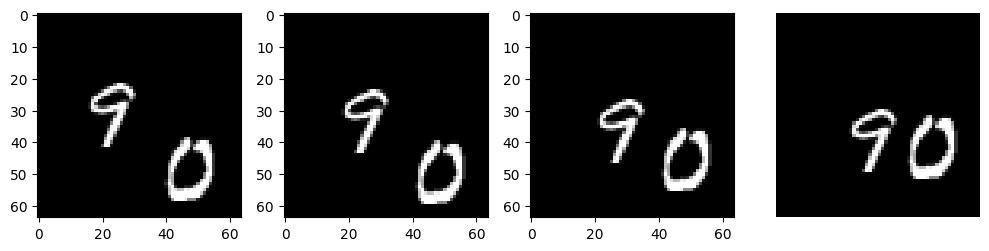

In [37]:
# visualization of the original frame with respect to 3 previous frames
all = [sample_x[0,:,:,i] for i in range(3)]+[sample_y[0,:,:,0]]
show_list(all)

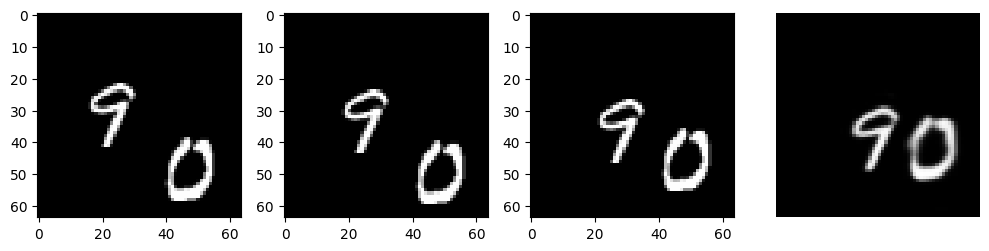

In [38]:
# visualization of the predicted frame with respect to 3 previous frames
all = [sample_x[0,:,:,i] for i in range(3)]+[predictions[0,:,:,0]]
show_list(all)

In [39]:
# Calculating the squared difference between original and predicted frame
squared_diff = np.square(sample_y[0,:,:,0] - predictions[0,:,:,0])

# Calculating the mean squared error
mse = np.mean(squared_diff)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.004964037114574194


## Testing on the entire Test set

In [48]:
from tqdm import tqdm

total_data_points = len(testset)

mse_total = 0.0
num_images = 0

num_batches = (total_data_points + batch - 1) // batch

# Initializing a counter variable
batch_count = 0

for batch_x, batch_y in tqdm(test_gen):
    # Predicting the images using the model
    predictions = model.predict(batch_x)

    # Calculating squared differences for the entire batch
    squared_diff = np.square(batch_y - predictions)

    # Calculating the mean squared error
    batch_mse = np.mean(squared_diff)

    # Accumulating MSE and count the number of images
    mse_total += batch_mse * batch_x.shape[0]
    num_images += batch_x.shape[0]

    # Incrementing the batch count
    batch_count += 1

    # Checking if the desired number of batches has been reached
    if batch_count >= num_batches:
        break

# Calculating average MSE
average_mse = mse_total / num_images

print("\n\n")
print(f"Average score: {average_mse:.16f}")


0it [00:00, ?it/s]

1/1 [==============================] - 0s 21ms/step



1it [00:00,  5.09it/s]

1/1 [==============================] - 0s 21ms/step



2it [00:00,  6.10it/s]

1/1 [==============================] - 0s 22ms/step



3it [00:00,  6.37it/s]

1/1 [==============================] - 0s 21ms/step



4it [00:00,  7.02it/s]

1/1 [==============================] - 0s 21ms/step



5it [00:00,  7.48it/s]

1/1 [==============================] - 0s 21ms/step



6it [00:00,  7.79it/s]

1/1 [==============================] - 0s 21ms/step



7it [00:00,  7.96it/s]

1/1 [==============================] - 0s 20ms/step



8it [00:01,  8.24it/s]

1/1 [==============================] - 0s 21ms/step



9it [00:01,  8.24it/s]

1/1 [==============================] - 0s 20ms/step



10it [00:01,  8.62it/s]

1/1 [==============================] - 0s 23ms/step



11it [00:01,  8.49it/s]

1/1 [==============================] - 0s 20ms/step



12it [00:01,  8.46it/s]

1/1 [==============================] - 0s 21ms/step



13it [00:01,  8.66it/s]

1/1 [==============================] - 0s 21ms/step



14it [00:01,  8.91it/s]

1/1 [==============================] - 0s 29ms/step



15it [00:01,  8.59it/s]

1/1 [==============================] - 0s 20ms/step



16it [00:01,  8.88it/s]

1/1 [==============================] - 0s 22ms/step



17it [00:02,  9.04it/s]

1/1 [==============================] - 0s 22ms/step



18it [00:02,  9.11it/s]

1/1 [==============================] - 0s 20ms/step



19it [00:02,  9.21it/s]

1/1 [==============================] - 0s 22ms/step



20it [00:02,  8.75it/s]

1/1 [==============================] - 0s 21ms/step



21it [00:02,  9.00it/s]

1/1 [==============================] - 0s 21ms/step



22it [00:02,  8.52it/s]

1/1 [==============================] - 0s 22ms/step



23it [00:02,  8.46it/s]

1/1 [==============================] - 0s 26ms/step



24it [00:02,  8.64it/s]

1/1 [==============================] - 0s 26ms/step



25it [00:03,  8.48it/s]

1/1 [==============================] - 0s 22ms/step



26it [00:03,  8.28it/s]

1/1 [==============================] - 0s 21ms/step



27it [00:03,  8.37it/s]

1/1 [==============================] - 0s 21ms/step



28it [00:03,  8.44it/s]

1/1 [==============================] - 0s 22ms/step



29it [00:03,  8.73it/s]

1/1 [==============================] - 0s 23ms/step



30it [00:03,  8.58it/s]

1/1 [==============================] - 0s 22ms/step



31it [00:03,  8.88it/s]

1/1 [==============================] - 0s 22ms/step


31it [00:03,  8.07it/s]




Average score: 0.0068637147267620
